# Dropout for image classication

In this tutorial, we will study how to use dropout to avoid overfitting when we have a limited training dataset. In particular, we will use dropout in a ConvNet classifier of the CIFAR-10 dataset, which is dataset consisting of images classified into ten differnt categories: 

Let me remind you that dropout is a regularizer technique that reduces the odds of overfitting by dropping out neurons at random, during every epoch (or, when using a minibatch approach, during every minibatch).

Ideally, we should determine the value for the dropout parameter with a validation set. However, it's perfectly fine to set it to 0.5, which has shown the best empirical results when being tested with the MNIST dataset.

To avoid holes in your input data, the dropout paramter for the input layer should be set to 1, that is, not applying dropout. 

Dropout seems to work best when a **combination of max-norm regularization** (in Keras, with the MaxNorm constraint), **high learning rates that decay to smaller values, and high momentum **is used as well.




Source: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-dropout-with-keras.md

In [11]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.constraints import max_norm
import tensorflow as tf

In [12]:
# Model configuration
img_width, img_height         = 32, 32
batch_size                    = 250
no_epochs                     = 10 # 55
no_classes                    = 10
validation_split              = 0.2
verbosity                     = 1
max_norm_value                = 2.0

## Load the CIFAR10 dataset

In [13]:
# Load CIFAR10 dataset
(input_train, target_train), (input_test, target_test) = cifar10.load_data()

# Reshape data based on channels first / channels last strategy.
# This is dependent on whether you use TF, Theano or CNTK as backend.
# Source: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
if K.image_data_format() == 'channels_first':
    input_train = input_train.reshape(input_train.shape[0],3, img_width, img_height)
    input_test = input_test.reshape(input_test.shape[0], 3, img_width, img_height)
    input_shape = (3, img_width, img_height)
else:
    input_train = input_train.reshape(input_train.shape[0], img_width, img_height, 3)
    input_test = input_test.reshape(input_test.shape[0], img_width, img_height, 3)
    input_shape = (img_width  , img_height, 3)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

# Convert target vectors to categorical targets
target_train = tf.keras.utils.to_categorical(target_train, no_classes)
target_test = tf.keras.utils.to_categorical(target_test, no_classes)


## Model without dropout

In [23]:
# Create the model without dropout
model1 = Sequential()
model1.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', input_shape=input_shape, kernel_initializer='he_uniform'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu', kernel_constraint=max_norm(max_norm_value), kernel_initializer='he_uniform'))
model1.add(Dense(no_classes, activation='softmax'))

# Compile the model
model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fit data to model
history_nodropout = model1.fit(input_train, target_train,
          batch_size=batch_size,
          epochs=no_epochs,
          verbose=verbosity,
          validation_split=validation_split
)

Epoch 1/10
160/160 [==============================] - 5s 27ms/step - loss: 1.6546 - accuracy: 0.4141 - val_loss: 1.4128 - val_accuracy: 0.5004
Epoch 2/10
160/160 [==============================] - 4s 25ms/step - loss: 1.2451 - accuracy: 0.5597 - val_loss: 1.2386 - val_accuracy: 0.5580
Epoch 3/10
160/160 [==============================] - 4s 24ms/step - loss: 1.0813 - accuracy: 0.6228 - val_loss: 1.0880 - val_accuracy: 0.6225
Epoch 4/10
160/160 [==============================] - 4s 24ms/step - loss: 0.9829 - accuracy: 0.6559 - val_loss: 1.0109 - val_accuracy: 0.6529
Epoch 5/10
160/160 [==============================] - 4s 26ms/step - loss: 0.8909 - accuracy: 0.6907 - val_loss: 0.9852 - val_accuracy: 0.6619
Epoch 6/10
160/160 [==============================] - 4s 24ms/step - loss: 0.8201 - accuracy: 0.7165 - val_loss: 0.9494 - val_accuracy: 0.6750
Epoch 7/10
160/160 [==============================] - 4s 26ms/step - loss: 0.7547 - accuracy: 0.7381 - val_loss: 0.9480 - val_accuracy: 0.6795

### Evaluation on the test dataset

In [24]:
# Generate generalization metrics
score = model1.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.8996272683143616 / Test accuracy: 0.7005000114440918


## Model using dropout

In [25]:
# Create the model
model2 = Sequential()
model2.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', input_shape=input_shape, kernel_initializer='he_uniform'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.50))
model2.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.50))
model2.add(Flatten())
model2.add(Dense(256, activation='relu', kernel_constraint=max_norm(max_norm_value), kernel_initializer='he_uniform'))
model2.add(Dense(no_classes, activation='softmax'))

# Compile the model
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fit data to model
history_dropout = model2.fit(input_train, target_train,
          batch_size=batch_size,
          epochs=no_epochs,
          verbose=verbosity,
          validation_split=validation_split
)

Epoch 1/10
160/160 [==============================] - 5s 28ms/step - loss: 2.1716 - accuracy: 0.2289 - val_loss: 1.8075 - val_accuracy: 0.3635
Epoch 2/10
160/160 [==============================] - 4s 27ms/step - loss: 1.6506 - accuracy: 0.3984 - val_loss: 1.5243 - val_accuracy: 0.4682
Epoch 3/10
160/160 [==============================] - 4s 26ms/step - loss: 1.4689 - accuracy: 0.4708 - val_loss: 1.3959 - val_accuracy: 0.5136
Epoch 4/10
160/160 [==============================] - 5s 29ms/step - loss: 1.3569 - accuracy: 0.5149 - val_loss: 1.2870 - val_accuracy: 0.5576
Epoch 5/10
160/160 [==============================] - 4s 25ms/step - loss: 1.2677 - accuracy: 0.5474 - val_loss: 1.1829 - val_accuracy: 0.5972
Epoch 6/10
160/160 [==============================] - 4s 27ms/step - loss: 1.1909 - accuracy: 0.5786 - val_loss: 1.1057 - val_accuracy: 0.6206
Epoch 7/10
160/160 [==============================] - 4s 27ms/step - loss: 1.1260 - accuracy: 0.6012 - val_loss: 1.0521 - val_accuracy: 0.6381

### Evaluation on the test dataset 


In [26]:
# Generate generalization metrics
score = model2.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.9926201105117798 / Test accuracy: 0.6531999707221985


## Learning curves
We create the learning curves for both models to see if there is overfitting.

In [28]:
import matplotlib.pyplot as plt
 
def print_learning_curves(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    
    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    #
    # Plot the model accuracy vs Epochs
    #
    ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
    ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
    ax[0].set_title('Training & Validation Accuracy', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('Accuracy', fontsize=16)
    ax[0].legend()
    #
    # Plot the loss vs Epochs
    #
    ax[1].plot(epochs, loss_values, 'b', label='Training loss')
    ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
    ax[1].set_title('Training & Validation Loss', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('Loss', fontsize=16)
    ax[1].legend()
    return



## Learning curves for the model without dropout

We can see that the model overfits the training dataset because the loss on the training dataset is much lower than the loss on the validation daetaset (closer to 1)

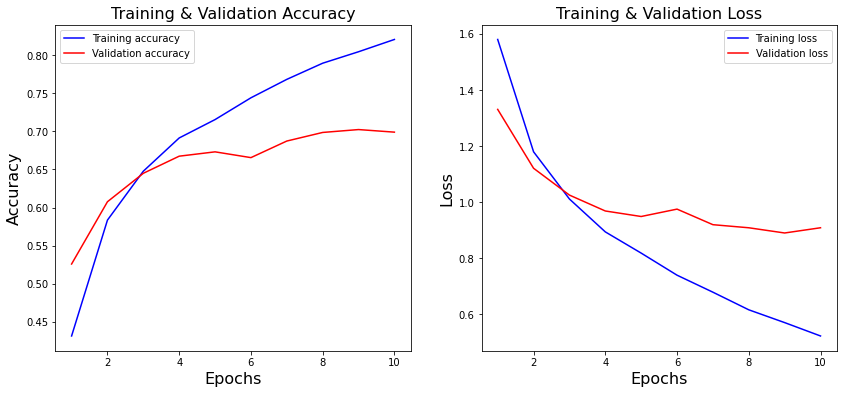

In [20]:
print_learning_curves(history_nodropout)

# Learning curves of the model with dropout

However, when the model uses dropout, we can see that the training and validation curves are very close. The bias and variance are low.

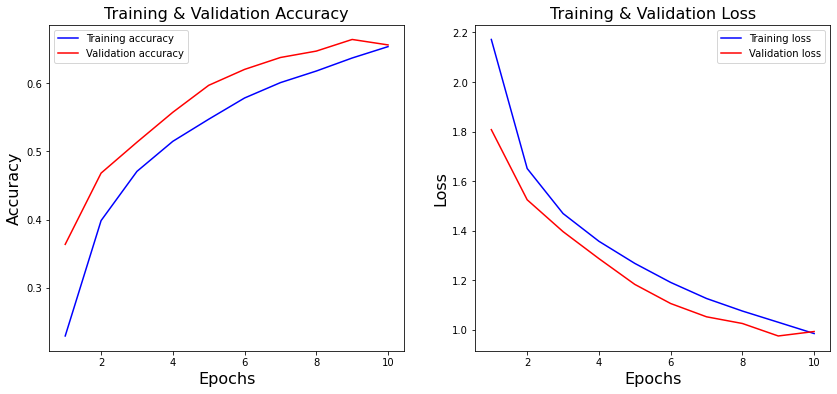

In [29]:
print_learning_curves(history_dropout)